In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy
from sklearn.preprocessing import normalize

### Import Glove document vectors

In [3]:
#gv_matrix = scipy.sparse.load_npz('../processed_files/gv_matrix.npz')
df_merged = pickle.load(open("../processed_files/df_merged.pickle", "rb"))

In [4]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PARSED
0,0-my.com,0-my.com related searches: related searches:,-my.com related searches: related searches:
1,00bitz.com,error. page cannot be displayed. please contac...,error. page cannot be displayed. please contac...
2,01187.com,01187.com is available for purchase! - wwwv1.c...,.com is available for purchase! - wwwv.com wel...
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...",".ir - dns.ir .ir hits: , under construction co..."
4,03h.org,february | 2014 | online marketing review sear...,february | | online marketing review search f...


In [5]:
df_merged.shape

(12956, 3)

In [6]:
gv_matrix = np.load("../processed_files/gv_matrix.npy", allow_pickle = True)

In [7]:
gv_matrix.shape

(12956, 300)

In [8]:
from sklearn.preprocessing import normalize
gv_matrix = normalize(gv_matrix, norm = 'l2', axis = 1)

## gv_matrix

In [9]:
%%time
nbrs = NearestNeighbors(n_neighbors = 10, algorithm = 'ball_tree').fit(gv_matrix)
distances, indices = nbrs.kneighbors(gv_matrix)

CPU times: user 1min 14s, sys: 67.5 ms, total: 1min 14s
Wall time: 1min 14s


In [77]:
indices[0]

array([    0,  4965,  4736,   250,  4000,  8843,  8588,  7384,  6572,
       10781,  2416,  3646,  3211,   166,   139,  9976,  5306, 11660,
        9810,  2098])

In [76]:
distances[0]

array([0.        , 0.32413445, 0.32413445, 0.32413445, 0.32413445,
       0.32413445, 0.32413445, 0.32413445, 0.32413445, 0.32413445,
       0.32413445, 0.32413445, 0.32413445, 0.32413445, 0.32413445,
       0.32413445, 0.32413445, 0.32413445, 0.32413445, 0.32413445])

In [91]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = gv_mat[index]
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid-gv_mat[i])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)
    
    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [92]:
intracluster_similarity(6)

(0.08755036113360462, 0.005574593261545156)

In [80]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [81]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(51)

In [110]:
avg_list = []
variance_list = []

for i in range(gv_mat.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x13d2f02b0>,
 <a list of 11 Text xticklabel objects>)

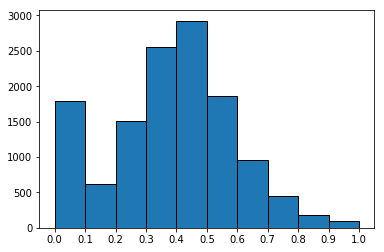

In [111]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x13e2c3358>,
 <a list of 11 Text xticklabel objects>)

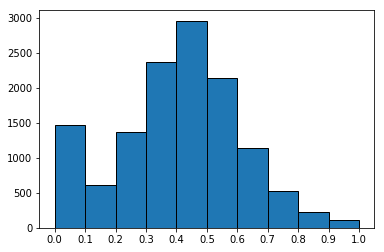

In [94]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x141e6ccf8>,
 <a list of 11 Text xticklabel objects>)

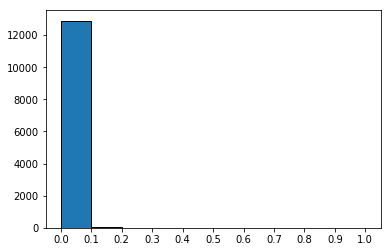

In [113]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x13d398f98>,
 <a list of 11 Text xticklabel objects>)

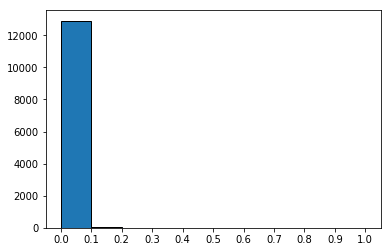

In [95]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [96]:
print(len(avg_list), len(variance_list))

12956 12956


## Intercluster Similarity

In [97]:
def calculate_centroid(index):
    cluster_centroid = gv_mat[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, gv_mat[i])
    return cluster_centroid/len(indices[index][1:])

In [114]:
index_centroid = dict()
for i in range(gv_mat.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [99]:
index_centroid[0]

array([-5.90528280e-03, -2.58864235e-02, -1.12546368e-01,  3.97926056e-02,
        4.05076931e-02,  2.12676118e-02,  3.12369516e-02, -2.05519427e-02,
        5.69234151e-02,  1.48120530e-01, -6.97298174e-02,  1.70072667e-02,
        1.14060867e-02, -6.52230141e-02, -1.25343578e-02, -2.07132477e-02,
       -1.07481577e-02,  2.04837398e-01,  4.98798776e-04,  2.68928356e-02,
        5.87692104e-02,  1.63943620e-03, -5.26047898e-02,  3.50478475e-02,
        5.96902608e-02,  6.97829252e-02, -3.40849933e-03, -1.40726580e-02,
        5.05267132e-02,  7.24341867e-02,  6.10195654e-02, -7.54989978e-02,
       -2.58331214e-02,  3.66939939e-02,  1.64368593e-02, -6.82146678e-02,
        7.73481032e-02, -5.40321958e-02, -7.45954205e-02, -4.07154367e-03,
        1.50359008e-02, -1.02658943e-01,  1.02661256e-01, -1.01984079e-02,
       -2.83316035e-02, -3.47763388e-02,  1.00615128e-01,  5.53004595e-02,
        1.51886350e-02,  9.90310422e-03, -1.17406664e-01,  1.46237219e-02,
        7.42874685e-02, -

In [24]:
#centroid_centroid_distance = {}
#for i in range(gv_matrix.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(gv_matrix.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance

In [102]:
from random import sample
def sample_mean_intercluster_dist(sample_size):
    indices_sample = sample(range(gv_matrix.shape[0]),sample_size)
    centroid_centroid_distance = {}
    for i in indices_sample:
        for j in indices_sample:
            if i < j:
                key = str(i) + "::" + str(j)
                centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
    return np.array(list(centroid_centroid_distance.values())).mean()

# neighbors = 10

## 10 documents sample

In [115]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.7652861098709361, 0.7099392010819022, 0.7315937390586523, 0.6489849603433768, 0.664804910924328]

0.7041217842558392


## 100 documents sample

In [116]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.7751471346274111, 0.8320802224324912, 0.7722423437773385, 0.7520202615353199, 0.7845683671902872]

0.7832116659125696


## 500 documents sample

In [117]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.7933756678550089, 0.8001456074165811, 0.813086026703745, 0.8068586949692659, 0.81422885920658]

0.8055389712302361


# neighbors = 20

## 10 documents sample

In [106]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.7253863081597591, 0.7178045211426843, 0.8106601993381902, 0.7473225754233453, 0.7258913612352027]

0.7454129930598364


## 100 documents sample

In [107]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.7015999654521454, 0.7249045594174532, 0.6483944187796858, 0.7266111934154872, 0.7387935025031785]

0.7080607279135901


## 500 documents sample

In [108]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.723703839526378, 0.7468896220062177, 0.7214327879662298, 0.7170816693802519, 0.7313149118658053]

0.7280845661489765
